## Import library

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import scikitplot as skplt

## Import data

In [137]:
X_train = pd.read_csv('./Data/X_train.csv')
y_train = pd.read_csv('./Data/y_train.csv')
X_test = pd.read_csv('./Data/X_test.csv')
y_test = pd.read_csv('./Data/y_test.csv')

woe = pd.read_csv('./Data/woe.csv')

# Modeling

## 1. Logistic regression

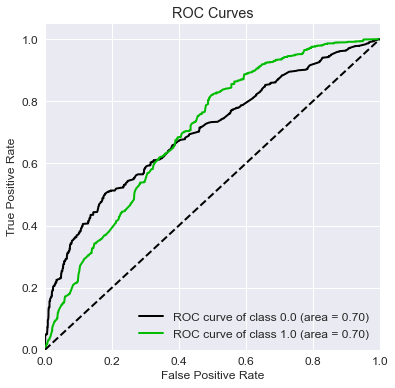

In [99]:
lr = LR(max_iter=100)
lr.fit(X_train,y_train.values.ravel())
y_predict = lr.predict(X_test)

test_proba_df = pd.DataFrame(lr.predict_proba(X_test)) 
skplt.metrics.plot_roc(y_test, test_proba_df,plot_micro=False,figsize=(6,6),plot_macro=False)
plt.show()

### Scorecard
Score $=offset -Factor * \ln ($ odds $)$  
"Offset" and "Factor" are constant. The $log(odd) represents the probability of default, which is coefficient in the model. 

In the begin, two assumption required:
1) A socre under certian PD
2) Points to double the odds (PDO)

For example, if the score of $odd = \frac{1}{60}$ is 800 and $PDO=50$, the score of $odd = \frac{1}{30}$ is $850$  

$800=A-B * \ln \left(\frac{1}{60}\right)$

$850=A-B * \ln \left(\frac{1}{30}\right)$

In [100]:
B = 50/np.log(2)
A = 800 + B*np.log(1/60)

In [133]:
x= 0
coef = pd.DataFrame(range(len(X_test.columns)),index = X_test.columns,columns = ["coef"])
coef["coef"]= coef["coef"].astype("float")
for i in X_test.columns:
    coef.loc[i]["coef"] = float(lr.coef_[0][x])
    x = x+ 1

In [138]:
woe.set_index(['Features','Value'],inplace=True)

In [148]:
base_score = A - B*lr.intercept_ 
print(base_score)

for i in X_test.columns:
    print(i)
    a = pd.DataFrame(woe["WoE"].loc[i] * coef["coef"].loc[i] * B)
    a.columns = ['Score']
    display(a)
    print(" ")

[513.02191631]
email


,Score
Value,
0,6.480632
1,-73.144014


 
income_type


,Score
Value,
Working,7.094749
Commercial associate,1.919242
Student / State servant / Pensioner,-82.508042


 
education_type


,Score
Value,
Secondary / secondary special,5.090852
others,-8.905262


 
family_status


,Score
Value,
Widow,11.537262
Married,5.981942
Single / not married / Civil marriage,-5.736767
Separated,-70.054889


 
housing_type


,Score
Value,
House / apartment,8.255301
Other,-91.394366


 
children_count


,Score
Value,
0,17.288114
1,-22.290083
over 2,-51.728243


 
family_members


,Score
Value,
<= 2,-1.596495
3.0,2.258959
>= 4,4.927330


 
occupation_type


,Score
Value,
IT/Drivers,42.439769
Laborers,13.320699
Sales/Accountants/Cooking/Managers/Core/Security/Secretaries/High skill,-2.398115
Nan,-13.833716
Realty/HR/Cleaning/Waiters/barmen/Private service/Medicine/Low-skill,-75.853509


 
working_yr_q


,Score
Value,
<= 3,16.165231
3~11,2.176937
11~22,-39.237038
>= 22,-106.419947


 
age_q


,Score
Value,
<= 34,16.962781
34~54,-1.903177
>= 54,-49.931309


## 2 Random Forest

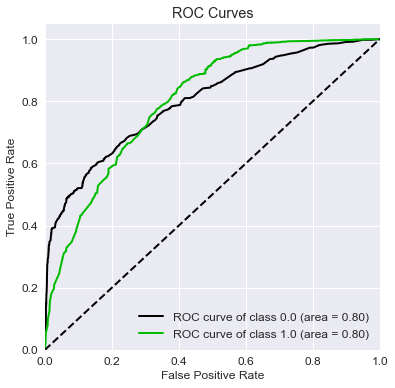

In [151]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=250,
                              max_depth=12,
                              min_samples_leaf=16
                              )
model.fit(X_train, y_train.values.ravel())
y_predict = model.predict(X_test)


test_proba_df = pd.DataFrame(model.predict_proba(X_test)) 
skplt.metrics.plot_roc(y_test, test_proba_df,plot_micro=False,figsize=(6,6),plot_macro=False)
plt.show()

## 3 SVM

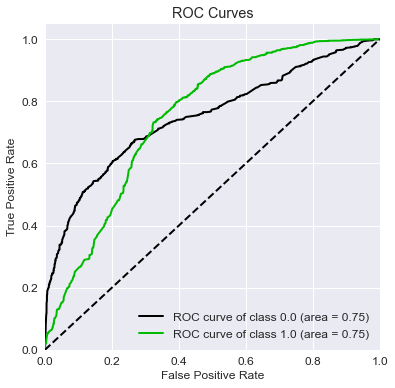

In [158]:
from sklearn import svm
model = svm.SVC(C = 0.8,
                kernel='rbf',
                 probability=True)
model.fit(X_train, y_train.values.ravel())
y_predict = model.predict(X_test)

test_proba_df = pd.DataFrame(model.predict_proba(X_test)) 
skplt.metrics.plot_roc(y_test, test_proba_df,plot_micro=False,figsize=(6,6),plot_macro=False)
plt.show()

## 4 XGBoost

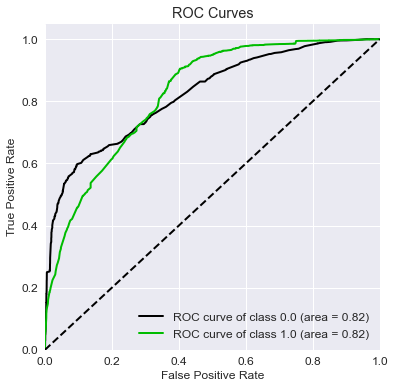

In [154]:
from xgboost import XGBClassifier
model = XGBClassifier(max_depth=12,
                      n_estimators=250,
                      min_child_weight=8, 
                      subsample=0.8, 
                      learning_rate =0.02, 
                      eval_metric = 'auc',
                      use_label_encoder=False,   
                      seed=42)

model.fit(X_train, y_train)
y_predict = model.predict(X_test)

test_proba_df = pd.DataFrame(model.predict_proba(X_test)) 
skplt.metrics.plot_roc(y_test, test_proba_df,plot_micro=False,figsize=(6,6),plot_macro=False)
plt.show()

## 5 lightgbm

/Users/song/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


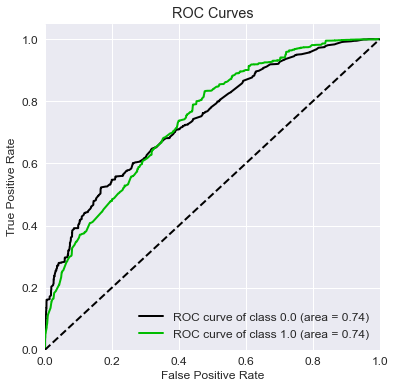

In [156]:
from lightgbm import LGBMClassifier
model = LGBMClassifier(num_leaves=31,
                       max_depth=8, 
                       learning_rate=0.02,
                       n_estimators=250,
                       subsample = 0.8,
                       colsample_bytree =0.8
                      )
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

test_proba_df = pd.DataFrame(model.predict_proba(X_test)) 
skplt.metrics.plot_roc(y_test, test_proba_df,plot_micro=False,figsize=(6,6),plot_macro=False)
plt.show()

## 6 Catboost

0:	learn: 0.5843219	total: 1.81s	remaining: 7m 30s
25:	learn: 0.3969407	total: 32.3s	remaining: 4m 37s
50:	learn: 0.3922424	total: 43.1s	remaining: 2m 48s
75:	learn: 0.3892188	total: 1m 39s	remaining: 3m 48s
100:	learn: 0.3883867	total: 2m 43s	remaining: 4m 1s
125:	learn: 0.3880187	total: 3m 18s	remaining: 3m 15s
150:	learn: 0.3878228	total: 3m 53s	remaining: 2m 33s
175:	learn: 0.3876954	total: 4m 26s	remaining: 1m 51s
200:	learn: 0.3876043	total: 5m 1s	remaining: 1m 13s
225:	learn: 0.3875405	total: 5m 40s	remaining: 36.1s
249:	learn: 0.3874941	total: 6m 1s	remaining: 0us


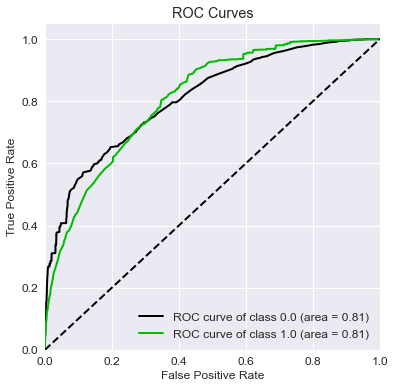

In [157]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=250,
                           learning_rate=0.2,
                           od_type='Iter',
                           verbose=25,
                           depth=16,
                           random_seed=42)

model.fit(X_train, y_train)
y_predict = model.predict(X_test)

test_proba_df = pd.DataFrame(model.predict_proba(X_test)) 
skplt.metrics.plot_roc(y_test, test_proba_df,plot_micro=False,figsize=(6,6),plot_macro=False)
plt.show()
